[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1LaeF0T-i7rawqlOJbuLiv-BLSuUu5Jaj?usp=sharing)

In [ ]:
!pip install -q torchview

In [ ]:
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.05

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min.to("cpu").numpy(), x_max.to("cpu").numpy(), h),
                         np.arange(y_min.to("cpu").numpy(), y_max.to("cpu").numpy(), h))
    grid = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid to pass into the model

    # Convert grid to a torch tensor and make predictions
    model.eval()
    with torch.inference_mode():
        grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
        preds = model(grid_tensor).squeeze()
        preds = (preds >= 0.5).float().to("cpu").numpy()

    Z = preds.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X.to("cpu").numpy()[:, 0], X.to("cpu").numpy()[:, 1],
                c=y.to("cpu").numpy().ravel(), cmap=plt.cm.Spectral, edgecolors="k")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [ ]:
N = 5000
X_np, y_np = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

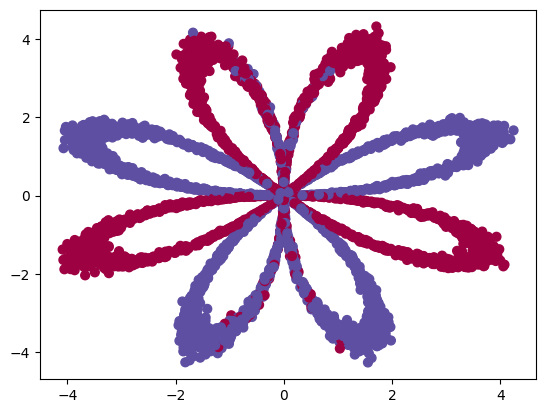

In [ ]:
# Visualize the data:
plt.scatter(X_np[:,0], X_np[:,1], c=y_np.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train_np, X_test_np, y_train_np, y_test_np) = train_test_split(
    X_np,
    y_np,
    test_size=0.2,
    random_state=14
)

In [ ]:
print('X shape:{0}, y shape:{1}'.format(X_np.shape, y_np.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train_np.shape,
                                                    y_train_np.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test_np.shape, y_test_np.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [ ]:
## X first example
X_np[0,:]

array([-1.52764533,  2.30646459])

In [ ]:
## Y firsts examples
y_np[:8]

array([0, 0, 1, 0, 0, 1, 0, 1], dtype=uint8)

In [ ]:
# convert numpy array to tensors
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.from_numpy(X_train_np).type(torch.float).to(device)
X_test = torch.from_numpy(X_test_np).type(torch.float).to(device)
y_train = torch.from_numpy(y_train_np).type(torch.float).to(device)
y_test = torch.from_numpy(y_test_np).type(torch.float).to(device)

print(f"y_test type: {type(y_test)}\nE.g.: {y_test[:8]}")

y_test type: <class 'torch.Tensor'>
E.g.: tensor([0., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0')


## First NN in torch



*   [**torch.nn**](https://pytorch.org/docs/stable/nn.html): basic building blocks to create NN architecture.
*   [**torch.nn.Parameter**](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter): tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters
*   [**torch.nn.Module**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module): base class for all neural network modules
*   [**torch.optim**](https://pytorch.org/docs/stable/optim.html): package implementing various optimization algorithms.




### Logistic regression

Fully connected layers are defined using the [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)

```python
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        ...

    def forward(self, x):
        ...
```

- **nn.module**: Contains all the building blocks of the neuronal network.
- **init**: initalise model parameters to be used several computations (these could be different layers from **torch.nn**, single paramters, etc.)
- **forward**: any nn.module need to overwrite the forward function to indicate model proper way to execute layers.

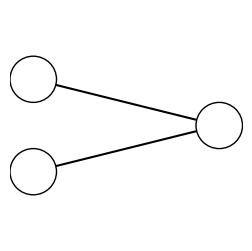

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

model = LogisticRegression(input_dim=2)

In [ ]:
# list parameters
model_params = list(model.parameters())
print(f"Trainable parameters n={len(model_params)}\n{model_params}")

# named parameters
print(f"\nNamed parameters: {model.state_dict()}")

Trainable parameters n=2
[Parameter containing:
tensor([[-0.0053,  0.3793]], requires_grad=True), Parameter containing:
tensor([-0.5820], requires_grad=True)]

Named parameters: OrderedDict([('linear.weight', tensor([[-0.0053,  0.3793]])), ('linear.bias', tensor([-0.5820]))])


In [ ]:
# models also have a device
next(model.parameters()).device

device(type='cpu')

In [ ]:
# architecture
print(model)

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


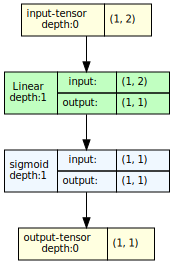

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [ ]:
# create the loss function
loss_fn = nn.BCELoss() # Binary cross entropy

# create the optimizer
optimizer = torch.optim.Adam(params=model.parameters())

#### Training model

Torch required to iterate over epochs and define each step

In [ ]:
def get_accuracy(y_hat, y):
    y_hat_class = (y_hat > 0.5).float()
    return (y == y_hat_class).float().mean() * 100

In [ ]:
epochs = 10

for epoch in range(epochs):
    ### Training

    # put model in training mode (this is the default state of a model)
    model.train()

    # 1. forward pass on train data
    y_pred = model(X_train).squeeze()

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. zero grad of the optimizer
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. progress the optimizer
    optimizer.step()

    ### Testing

    # put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # 1. forward pass on test data
      test_pred = model(X_test).squeeze()

      # 2. Calculate metrics for test and train
      test_accuracy = get_accuracy(test_pred, y_test)
      train_accuracy = get_accuracy(y_pred, y_train)

      # 3. caculate loss on test data
      test_loss = loss_fn(test_pred, y_test)

      # Display metrics every epoch
      if epoch % 1 == 0:
            print(f"Epoch: {epoch} | Train Loss={loss:.2f} & Accuracy={train_accuracy:.2f} " \
                  f"| Test Loss={test_loss:.2f} & Accuracy={test_accuracy:.2f}\n")

Epoch: 0 | Train Loss=0.90 & Accuracy=40.93 | Test Loss=0.89 & Accuracy=42.20

Epoch: 1 | Train Loss=0.90 & Accuracy=40.78 | Test Loss=0.89 & Accuracy=42.00

Epoch: 2 | Train Loss=0.90 & Accuracy=40.75 | Test Loss=0.89 & Accuracy=42.00

Epoch: 3 | Train Loss=0.90 & Accuracy=40.73 | Test Loss=0.89 & Accuracy=41.90

Epoch: 4 | Train Loss=0.90 & Accuracy=40.63 | Test Loss=0.89 & Accuracy=41.90

Epoch: 5 | Train Loss=0.90 & Accuracy=40.60 | Test Loss=0.88 & Accuracy=41.80

Epoch: 6 | Train Loss=0.90 & Accuracy=40.58 | Test Loss=0.88 & Accuracy=41.80

Epoch: 7 | Train Loss=0.90 & Accuracy=40.58 | Test Loss=0.88 & Accuracy=41.80

Epoch: 8 | Train Loss=0.90 & Accuracy=40.55 | Test Loss=0.88 & Accuracy=41.70

Epoch: 9 | Train Loss=0.90 & Accuracy=40.53 | Test Loss=0.88 & Accuracy=41.80



#### Making predictions

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

Test Accuracy: 41.80


In [ ]:
# clasification metrics
from sklearn.metrics import confusion_matrix, classification_report

y_preds_np = y_preds.to("cpu").numpy()
y_pred_class = (y_preds_np > 0.5).astype('int32')

print(confusion_matrix(y_test_np, y_pred_class))
print(classification_report(y_test_np, y_pred_class))

[[335 158]
 [424  83]]
              precision    recall  f1-score   support

           0       0.44      0.68      0.54       493
           1       0.34      0.16      0.22       507

    accuracy                           0.42      1000
   macro avg       0.39      0.42      0.38      1000
weighted avg       0.39      0.42      0.38      1000



Text(0.5, 1.0, 'Binary Classification Decision Boundary with PyTorch Model')

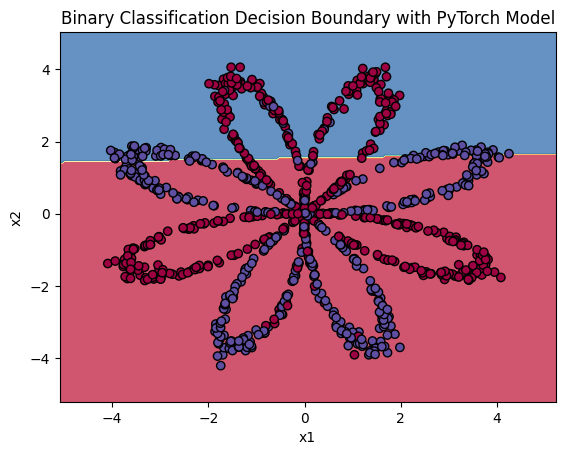

In [ ]:
plot_decision_boundary(model, X_test, y_test)
plt.title("Binary Classification Decision Boundary with PyTorch Model")

### One hidden layer NN

https://playground.tensorflow.org/

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

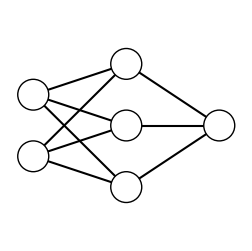

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [ ]:
class OneHiddenNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=input_dim, out_features=3)
        self.head_layer = nn.Linear(in_features=3, out_features=1)

    def forward(self, x):
        out = self.hidden_layer(x)
        out = self.head_layer(out)
        # remove sigmoid here (we'll see why)
        # out = torch.sigmoid(out)

        return out

model = OneHiddenNN(input_dim=2)
model

OneHiddenNN(
  (hidden_layer): Linear(in_features=2, out_features=3, bias=True)
  (head_layer): Linear(in_features=3, out_features=1, bias=True)
)

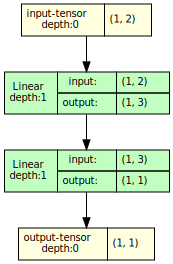

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

In [ ]:
## define loss and get optimizer
# We use a new loss (more numerically stable)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

**The missing part: batch size.**

So far we have updated the weights of our models using all the training data. As we saw in the theory, with more complex networks and more data volume this is not optimal. Therefore we must introduce gradient descent via mini batch.

- [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset): Dataset wrapping tensors. Each sample will be retrieved by indexing tensors along the first dimension
- [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): combines a dataset and a sampler, and provides an iterable over the given dataset



In [ ]:
## add batch size to work with mini batch gradient descend
batch_size = 8

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
## training
epochs = 10

# create a function to not replicate code
def training_nn(model, train_dataset, test_dataset, loss_fn, optimizer, epochs, batch_size, verbose=1):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        # put model in training mode
        model.train()

        running_train_loss = 0.0
        running_train_accuracy = 0.0

        for X_batch, y_batch in train_loader:
            # forward pass on train data
            y_logits = model(X_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            # calculate the loss (use logits to compute loss function)
            loss = loss_fn(y_logits, y_batch)

            # zero grad of the optimizer
            optimizer.zero_grad()

            # loss backward
            loss.backward()

            # progress the optimizer
            optimizer.step()

            # calculate accuracy for this batch
            train_accuracy = get_accuracy(y_pred, y_batch)

            # accumulate loss and accuracy for the epoch
            running_train_loss += loss.item()
            running_train_accuracy += train_accuracy.item()

        # average training loss and accuracy over all batches
        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_accuracy = running_train_accuracy / len(train_loader)

        ### Testing

        model.eval()
        running_test_loss = 0.0
        running_test_accuracy = 0.0

        with torch.inference_mode():
            for X_batch, y_batch in test_loader:
                # forward pass on test data
                test_pred = model(X_batch).squeeze()

                # calculate test loss
                test_loss = loss_fn(test_pred, y_batch)

                # calculate accuracy for this batch
                test_accuracy = get_accuracy(test_pred, y_batch)

                # accumulate test loss and accuracy
                running_test_loss += test_loss.item()
                running_test_accuracy += test_accuracy.item()

            # average test loss and accuracy over all batches
            avg_test_loss = running_test_loss / len(test_loader)
            avg_test_accuracy = running_test_accuracy / len(test_loader)

        # print metrics every epoch
        if verbose > 0:
            print(f"Epoch: {epoch} | Train Loss={avg_train_loss:.2f} & Accuracy={avg_train_accuracy:.2f}% | "
                  f"Test Loss={avg_test_loss:.2f} & Accuracy={avg_test_accuracy:.2f}%\n")


training_nn(model, train_dataset, test_dataset, loss_fn, optimizer, epochs, batch_size)

Epoch: 0 | Train Loss=0.67 & Accuracy=52.33% | Test Loss=0.67 & Accuracy=60.80%

Epoch: 1 | Train Loss=0.66 & Accuracy=48.92% | Test Loss=0.66 & Accuracy=61.80%

Epoch: 2 | Train Loss=0.66 & Accuracy=47.58% | Test Loss=0.67 & Accuracy=61.10%

Epoch: 3 | Train Loss=0.66 & Accuracy=48.48% | Test Loss=0.66 & Accuracy=61.80%

Epoch: 4 | Train Loss=0.66 & Accuracy=47.75% | Test Loss=0.67 & Accuracy=62.20%

Epoch: 5 | Train Loss=0.66 & Accuracy=47.77% | Test Loss=0.67 & Accuracy=59.80%

Epoch: 6 | Train Loss=0.66 & Accuracy=48.67% | Test Loss=0.67 & Accuracy=61.10%

Epoch: 7 | Train Loss=0.66 & Accuracy=48.05% | Test Loss=0.67 & Accuracy=60.70%

Epoch: 8 | Train Loss=0.66 & Accuracy=48.35% | Test Loss=0.66 & Accuracy=61.60%

Epoch: 9 | Train Loss=0.66 & Accuracy=48.05% | Test Loss=0.66 & Accuracy=62.00%



Test Accuracy: 62.00


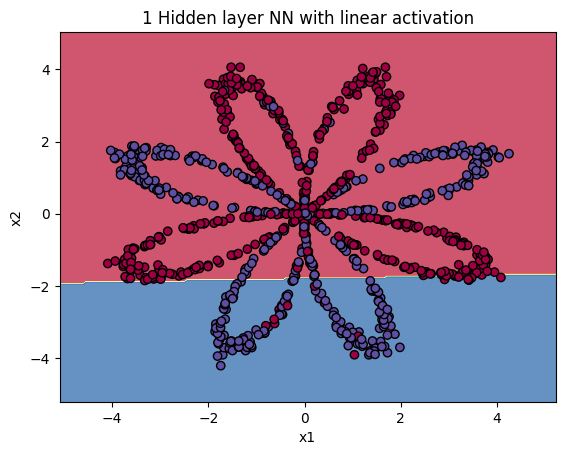

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

plot_decision_boundary(model, X_test, y_test)
plt.title("1 Hidden layer NN with linear activation");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'sigmoid'`?

In [ ]:
class OneHiddenNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=input_dim, out_features=3)
        self.head_layer = nn.Linear(in_features=3, out_features=1)

    def forward(self, x):
        out = self.hidden_layer(x)
        out = torch.sigmoid(out)
        out = self.head_layer(out)

        return out

model = OneHiddenNN(input_dim=2)
model

OneHiddenNN(
  (hidden_layer): Linear(in_features=2, out_features=3, bias=True)
  (head_layer): Linear(in_features=3, out_features=1, bias=True)
)

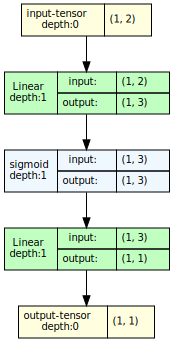

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

In [ ]:
## define loss and get optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

training_nn(model, train_dataset, test_dataset, loss_fn, optimizer, epochs, batch_size)

Epoch: 0 | Train Loss=0.68 & Accuracy=55.40% | Test Loss=0.67 & Accuracy=50.90%

Epoch: 1 | Train Loss=0.66 & Accuracy=67.47% | Test Loss=0.66 & Accuracy=49.70%

Epoch: 2 | Train Loss=0.65 & Accuracy=69.08% | Test Loss=0.66 & Accuracy=52.30%

Epoch: 3 | Train Loss=0.64 & Accuracy=68.97% | Test Loss=0.65 & Accuracy=54.50%

Epoch: 4 | Train Loss=0.63 & Accuracy=67.50% | Test Loss=0.63 & Accuracy=55.00%

Epoch: 5 | Train Loss=0.62 & Accuracy=67.03% | Test Loss=0.62 & Accuracy=55.50%

Epoch: 6 | Train Loss=0.60 & Accuracy=66.50% | Test Loss=0.61 & Accuracy=62.10%

Epoch: 7 | Train Loss=0.59 & Accuracy=66.28% | Test Loss=0.60 & Accuracy=63.80%

Epoch: 8 | Train Loss=0.58 & Accuracy=66.05% | Test Loss=0.59 & Accuracy=64.90%

Epoch: 9 | Train Loss=0.58 & Accuracy=65.97% | Test Loss=0.58 & Accuracy=65.70%



Test Accuracy: 65.70


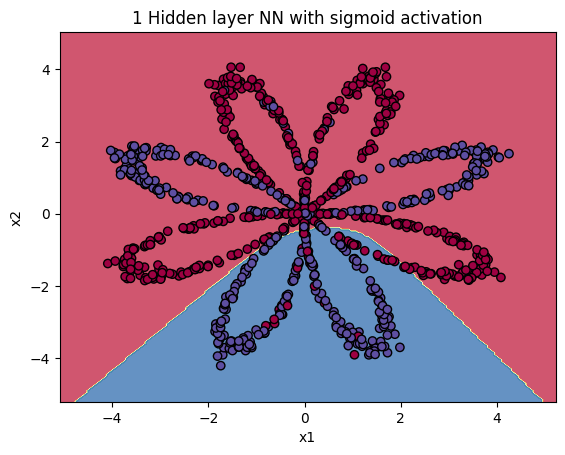

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

plot_decision_boundary(model, X_test, y_test)
plt.title("1 Hidden layer NN with sigmoid activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

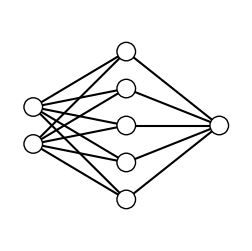

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [ ]:
class OneHiddenNN(nn.Module):
    def __init__(self, input_dim, hidden_neurons):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=input_dim, out_features=hidden_neurons)
        self.head_layer = nn.Linear(in_features=hidden_neurons, out_features=1)

    def forward(self, x):
        out = self.hidden_layer(x)
        out = torch.sigmoid(out)
        out = self.head_layer(out)

        return out

model = OneHiddenNN(input_dim=2, hidden_neurons=5)
model

OneHiddenNN(
  (hidden_layer): Linear(in_features=2, out_features=5, bias=True)
  (head_layer): Linear(in_features=5, out_features=1, bias=True)
)

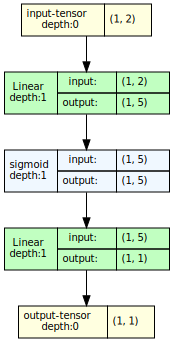

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

In [ ]:
## define loss and get optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

training_nn(model, train_dataset, test_dataset, loss_fn, optimizer, epochs, batch_size)

Epoch: 0 | Train Loss=0.69 & Accuracy=52.02% | Test Loss=0.67 & Accuracy=49.30%

Epoch: 1 | Train Loss=0.66 & Accuracy=55.05% | Test Loss=0.65 & Accuracy=58.00%

Epoch: 2 | Train Loss=0.64 & Accuracy=50.55% | Test Loss=0.63 & Accuracy=63.30%

Epoch: 3 | Train Loss=0.62 & Accuracy=51.20% | Test Loss=0.62 & Accuracy=65.50%

Epoch: 4 | Train Loss=0.60 & Accuracy=50.60% | Test Loss=0.60 & Accuracy=65.90%

Epoch: 5 | Train Loss=0.59 & Accuracy=49.62% | Test Loss=0.59 & Accuracy=67.10%

Epoch: 6 | Train Loss=0.58 & Accuracy=52.60% | Test Loss=0.58 & Accuracy=67.50%

Epoch: 7 | Train Loss=0.57 & Accuracy=52.45% | Test Loss=0.58 & Accuracy=67.40%

Epoch: 8 | Train Loss=0.57 & Accuracy=53.15% | Test Loss=0.57 & Accuracy=66.30%

Epoch: 9 | Train Loss=0.56 & Accuracy=53.30% | Test Loss=0.57 & Accuracy=66.30%



Test Accuracy: 66.30


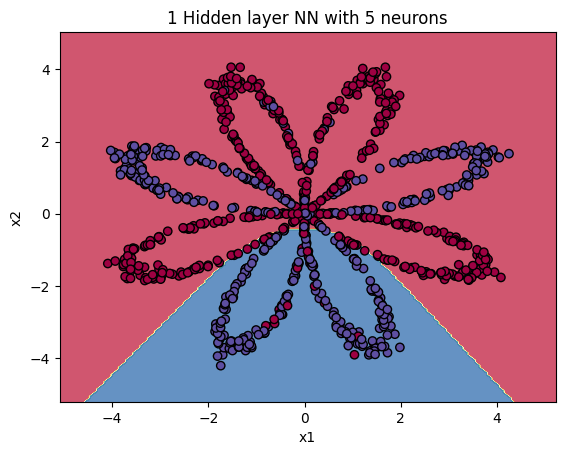

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

plot_decision_boundary(model, X_test, y_test)
plt.title("1 Hidden layer NN with 5 neurons");

### Question 3:
####  What happens if we add one more hidden layer ?

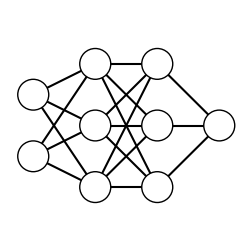

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [ ]:
class TwoHiddenNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden_layer_1 = nn.Linear(in_features=input_dim, out_features=3)
        self.hidden_layer_2 = nn.Linear(in_features=3, out_features=3)
        self.head_layer = nn.Linear(in_features=3, out_features=1)

    def forward(self, x):
        out = self.hidden_layer_1(x)
        out = torch.sigmoid(out)
        out = self.hidden_layer_2(out)
        out = torch.sigmoid(out)
        out = self.head_layer(out)

        return out

model = TwoHiddenNN(input_dim=2)
model

TwoHiddenNN(
  (hidden_layer_1): Linear(in_features=2, out_features=3, bias=True)
  (hidden_layer_2): Linear(in_features=3, out_features=3, bias=True)
  (head_layer): Linear(in_features=3, out_features=1, bias=True)
)

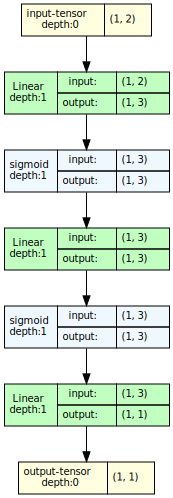

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

In [ ]:
## define loss and get optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

training_nn(model, train_dataset, test_dataset, loss_fn, optimizer, epochs, batch_size)

Epoch: 0 | Train Loss=0.69 & Accuracy=53.02% | Test Loss=0.69 & Accuracy=49.30%

Epoch: 1 | Train Loss=0.69 & Accuracy=58.40% | Test Loss=0.68 & Accuracy=49.30%

Epoch: 2 | Train Loss=0.68 & Accuracy=60.38% | Test Loss=0.67 & Accuracy=49.30%

Epoch: 3 | Train Loss=0.66 & Accuracy=63.62% | Test Loss=0.66 & Accuracy=49.30%

Epoch: 4 | Train Loss=0.65 & Accuracy=64.97% | Test Loss=0.64 & Accuracy=55.30%

Epoch: 5 | Train Loss=0.63 & Accuracy=65.45% | Test Loss=0.62 & Accuracy=64.00%

Epoch: 6 | Train Loss=0.61 & Accuracy=65.70% | Test Loss=0.61 & Accuracy=65.60%

Epoch: 7 | Train Loss=0.60 & Accuracy=65.80% | Test Loss=0.60 & Accuracy=66.20%

Epoch: 8 | Train Loss=0.59 & Accuracy=65.25% | Test Loss=0.59 & Accuracy=66.90%

Epoch: 9 | Train Loss=0.58 & Accuracy=65.50% | Test Loss=0.58 & Accuracy=67.40%



Test Accuracy: 67.40


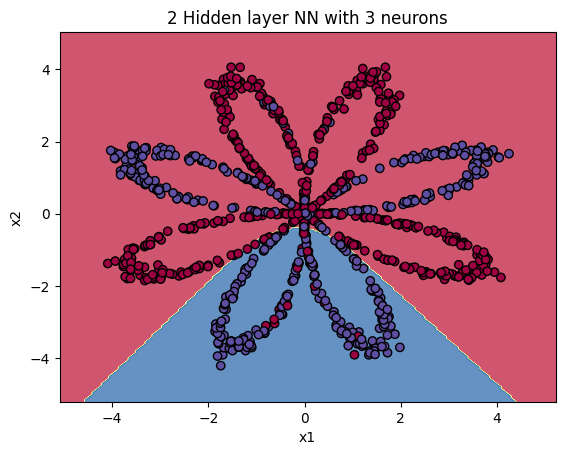

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

plot_decision_boundary(model, X_test, y_test)
plt.title("2 Hidden layer NN with 3 neurons");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [ ]:
class OneHiddenNN(nn.Module):
    def __init__(self, input_dim, hidden_neurons):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=input_dim, out_features=hidden_neurons)
        self.head_layer = nn.Linear(in_features=hidden_neurons, out_features=1)

    def forward(self, x):
        out = self.hidden_layer(x)
        out = torch.tanh(out)
        out = self.head_layer(out)

        return out

model = OneHiddenNN(input_dim=2, hidden_neurons=5)
model

OneHiddenNN(
  (hidden_layer): Linear(in_features=2, out_features=5, bias=True)
  (head_layer): Linear(in_features=5, out_features=1, bias=True)
)

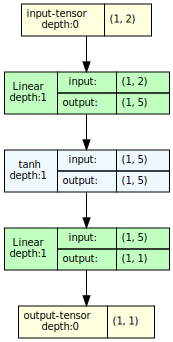

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

In [ ]:
## define loss and get optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

training_nn(model, train_dataset, test_dataset, loss_fn, optimizer, epochs, batch_size)

Epoch: 0 | Train Loss=0.68 & Accuracy=59.23% | Test Loss=0.65 & Accuracy=62.60%

Epoch: 1 | Train Loss=0.63 & Accuracy=64.60% | Test Loss=0.62 & Accuracy=65.00%

Epoch: 2 | Train Loss=0.60 & Accuracy=58.92% | Test Loss=0.59 & Accuracy=66.50%

Epoch: 3 | Train Loss=0.57 & Accuracy=62.92% | Test Loss=0.55 & Accuracy=67.50%

Epoch: 4 | Train Loss=0.52 & Accuracy=80.62% | Test Loss=0.49 & Accuracy=78.90%

Epoch: 5 | Train Loss=0.46 & Accuracy=85.28% | Test Loss=0.44 & Accuracy=83.30%

Epoch: 6 | Train Loss=0.42 & Accuracy=88.15% | Test Loss=0.41 & Accuracy=84.50%

Epoch: 7 | Train Loss=0.39 & Accuracy=89.62% | Test Loss=0.38 & Accuracy=84.80%

Epoch: 8 | Train Loss=0.36 & Accuracy=90.58% | Test Loss=0.36 & Accuracy=85.80%

Epoch: 9 | Train Loss=0.34 & Accuracy=91.50% | Test Loss=0.34 & Accuracy=85.80%



Test Accuracy: 85.80


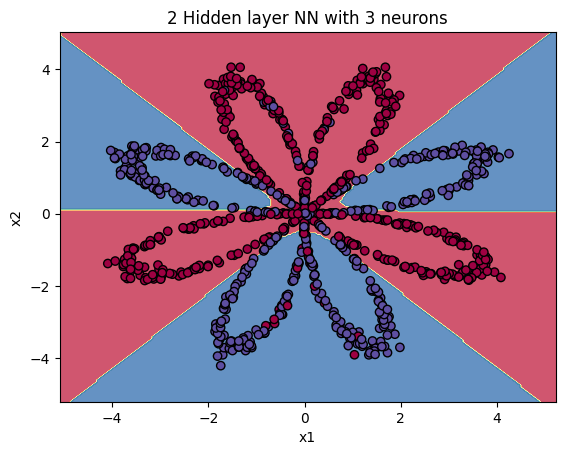

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

plot_decision_boundary(model, X_test, y_test)
plt.title("2 Hidden layer NN with 3 neurons");

## Practice I

Repeat the process with a different dataset.

In [ ]:
N = 5000
X_np, y_np = sklearn.datasets.make_moons(n_samples=N, noise=.18)

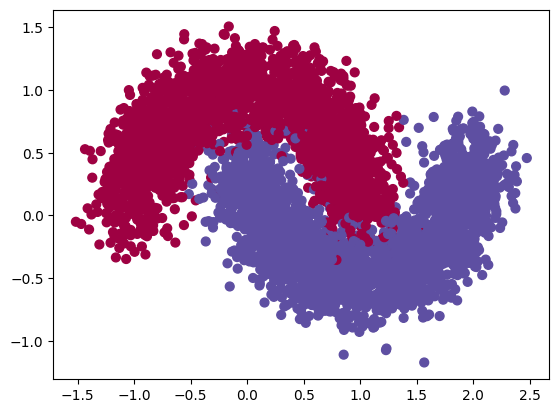

In [ ]:
# Visualize the data:
plt.scatter(X_np[:,0], X_np[:,1], c=y_np.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train_np, X_test_np, y_train_np, y_test_np) = train_test_split(
    X_np,
    y_np,
    test_size=0.2,
    random_state=14,
)

# convert numpy array to tensors

X_train = torch.from_numpy(X_train_np).type(torch.float).to(device)
X_test = torch.from_numpy(X_test_np).type(torch.float).to(device)
y_train = torch.from_numpy(y_train_np).type(torch.float).to(device)
y_test = torch.from_numpy(y_test_np).type(torch.float).to(device)

print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.size(),
                                                    y_train.size()))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.size(), y_test.size()))

### Define your model

In [ ]:
class SolutionModel(nn.Module):
    def __init__(self, ...):
        super().__init__()
        ...

    def forward(self, x):
        ...

model = ...

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(..., input_size=(1, 2), expand_nested=True)
model_graph.visual_graph

In [ ]:
## define loss and get optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=...)

## create your tensor dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = ...
training_nn(model, train_dataset, test_dataset, loss, optimizer, epochs, batch_size)

In [ ]:
with torch.inference_mode():
    y_preds = model(X_test).squeeze()

print(f'Test Accuracy: {get_accuracy(y_preds, y_test):.2f}')

plot_decision_boundary(model, X_test, y_test)
plt.title("Solution");

## Sequential mode

There is another way to define the architecture of our neural networks with torch, and that is by using the [sequential module](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential). The output of the previous layer serves as input to the next layer without allowing any distinct execution flow.

In [ ]:
input_dim = 2
output_dim = 1

seq_model = nn.Sequential(
    nn.Linear(input_dim, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, output_dim)
)

seq_model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

## Visualize decision boundary by epoch

In [ ]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import os

In [ ]:
def plot_save_decision_boundary(model, X, y, epoch, epoch_image):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min.to("cpu").numpy(), x_max.to("cpu").numpy(), h),
                         np.arange(y_min.to("cpu").numpy(), y_max.to("cpu").numpy(), h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    # Convert grid to a torch tensor and make predictions
    model.eval()
    with torch.inference_mode():
        grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
        Z = model(grid_tensor).squeeze()
        Z = (Z >= 0.5).float().to("cpu").numpy()

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, colors=['blue', 'red'], levels=[-0.5, 0.5, 1.5])
    X_np = X.to("cpu").numpy()
    y_np = y.to("cpu").numpy()
    plt.scatter(X_np[y_np == 0][:, 0], X_np[y_np == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X_np[y_np == 1][:, 0], X_np[y_np == 1][:, 1], color='red', label='Class 1', alpha=0.5)
    plt.title(f'Epoch {epoch}')
    plt.savefig(epoch_image)
    plt.close()

def generate_spiral_dataset(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise

    X, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))
    return X, y.reshape(-1, 1)

n_points = 2500
X_np, y_np = generate_spiral_dataset(n_points)

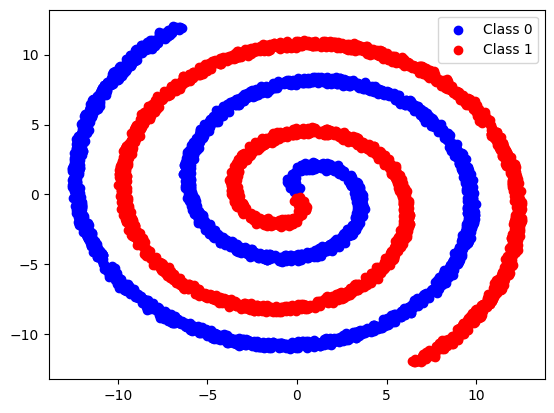

In [ ]:
plt.scatter(X_np[y_np[:, 0] == 0][:, 0], X_np[y_np[:, 0] == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_np[y_np[:, 0] == 1][:, 0], X_np[y_np[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.show()

In [ ]:
# Normalize data
(X_train_np, X_test_np, y_train_np, y_test_np) = train_test_split(
    X_np,
    y_np,
    test_size=0.3,
    random_state=14
)

# # Apply normalization using sklearn
# scaler = StandardScaler()
# X_train_np = scaler.fit_transform(X_train_np)
# X_test_np = scaler.transform(X_test_np)

# convert numpy array to tensors
X_train = torch.from_numpy(X_train_np).type(torch.float).to(device)
X_test = torch.from_numpy(X_test_np).type(torch.float).to(device)
y_train = torch.from_numpy(y_train_np).type(torch.float).to(device).squeeze()
y_test = torch.from_numpy(y_test_np).type(torch.float).to(device).squeeze()

print('X shape:{0}, y shape:{1}'.format(X_np.shape, y_np.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.size(),
                                                    y_train.size()))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.size(), y_test.size()))

# replicate standard scaler of sklearn with torch
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)
print(f"\nStandardScaler\nmean={mean} std={std}")
print(f"Original X_train {X_train[:5]}")
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
print(f"Standarized X_train {X_train[:5]}")

X shape:(5000, 2), y shape:(5000, 1)
X_train shape:torch.Size([3500, 2]), y_train shape:torch.Size([3500])
X_test shape:torch.Size([1500, 2]), y_test shape:torch.Size([1500])

StandardScaler
mean=tensor([-0.0088,  0.0134], device='cuda:0') std=tensor([7.1719, 6.3808], device='cuda:0')
Original X_train tensor([[ 7.6741, -6.2865],
        [ 5.8648, -3.5484],
        [-1.2348, -4.3328],
        [-5.2000, -1.8311],
        [-1.6516, -4.3215]], device='cuda:0')
Standarized X_train tensor([[ 1.0713, -0.9873],
        [ 0.8190, -0.5582],
        [-0.1709, -0.6811],
        [-0.7238, -0.2891],
        [-0.2291, -0.6794]], device='cuda:0')


In [ ]:
lr_list = [0.00001, 0.01, 0.1]

# define model architecture
class LRExperiments(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=input_dim, out_features=16)
        self.head_layer = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        out = self.hidden_layer(x)
        out = torch.relu(out)
        out = self.head_layer(out)

        return out


# Store the models in a list
model_dict = {}
for i, lr in enumerate(lr_list):
  model = LRExperiments(input_dim=2)
  model.to(device)
  model_dict[f"model_{i}"] = {"model": model,
                              "loss": nn.BCEWithLogitsLoss(),
                              "optimizer": torch.optim.Adam(params=model.parameters(), lr=lr)}

n_epochs = 60
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
epoch_images = {}

for i in range(len(model_dict)):
  epoch_images[i] = []

for epoch in range(n_epochs):
    for ix, (k, v) in enumerate(model_dict.items()):
      training_nn(v["model"], train_dataset, test_dataset, v["loss"], v["optimizer"],
                  1, batch_size, verbose=0)
      epoch_image = f'epoch_{epoch}_{k}.png'
      epoch_images[ix].append(epoch_image)

      plot_save_decision_boundary(v["model"], X_test, y_test, epoch, epoch_image)

In [ ]:
from PIL import Image as Image_PIL

# Create the GIF

for ix in range(len(model_dict)):
  gif_filename = f'epoch_animation_model_{ix}.gif'
  images = [Image_PIL.open(epoch_image) for epoch_image in epoch_images[ix]]

  duration = 0.15
  images[0].save(gif_filename,
              format='GIF',
              append_images=images[1:],
              save_all=True,
              duration=duration*1000,
              loop=0)

  # Delete the individual epoch images
  for epoch_image in epoch_images[ix]:
      os.remove(epoch_image)

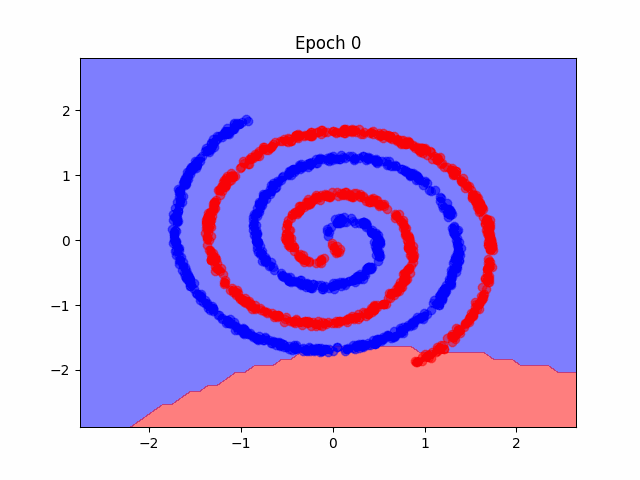

In [ ]:
# Model with LR=0.0001
Image(filename='epoch_animation_model_0.gif')

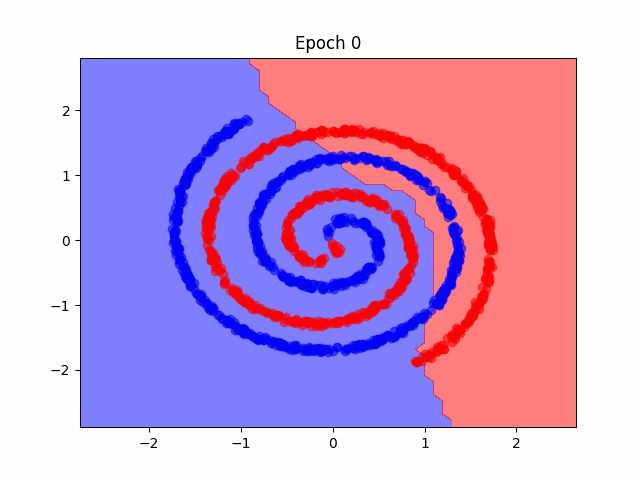

In [ ]:
# Model with LR=0.01
Image(filename='epoch_animation_model_1.gif')

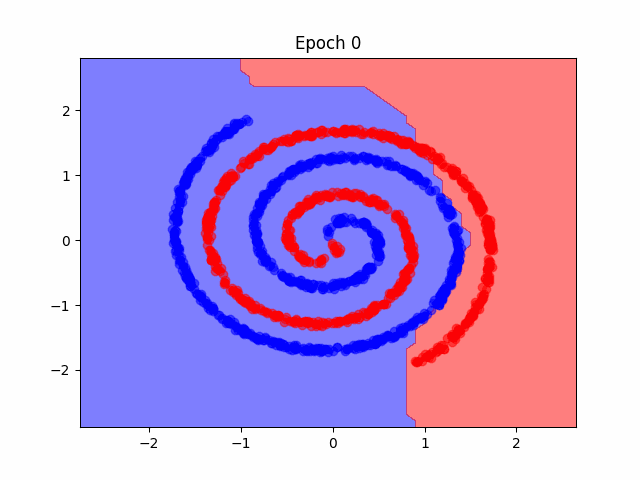

In [ ]:
# Model with LR=0.1
Image(filename='epoch_animation_model_2.gif')